# Learning LSTM Autoencoder and LSTM Network on a simple Multivariate Timeseries Toy example

In [387]:
# lstm autoencoder to recreate a timeseries
import pandas as pd
import numpy as np
import ta
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Input
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.rcParams['figure.figsize'] = [20, 10]

In [388]:
'''
A UDF to convert input data into 3-D
array as required for LSTM network.
'''

def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [389]:
csv_path = '../data/btc_15m.csv'
df = pd.read_csv(csv_path, sep=',')
# df = df.drop(columns=['quote_asset_volume', 'number_of_trades',
#                       'buy_base_asset_volume', 'buy_quote_asset_volume', 'open_time', 'close_time', 'ignore'], axis=1)
# df = df.drop(columns=['Adj Close', 'Date'], axis=1)
df = ta.utils.dropna(df)
train_data = df.copy()

data = ta.add_all_ta_features(
    train_data, open='open', high='high', low='low',
    close='close', volume='volume', fillna=True
)

raw_price = data.close.astype('float64').values
timeseries = data.drop(columns=['open', 'high', 'low', 'close', 'volume'], axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(timeseries)
timeseries = scaler.transform(timeseries)
timesteps = timeseries.shape[0]
n_features = timeseries.shape[1]
timeseries.shape

c:\users\thinh\miniconda3\envs\p36\lib\site-packages\ta\trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
c:\users\thinh\miniconda3\envs\p36\lib\site-packages\ta\trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


(96292, 72)

In [390]:
timesteps = 15
X, y = temporalize(X=timeseries, y=np.zeros(len(timeseries)), lookback = timesteps)

n_features = 72
X = np.array(X)
X = X.reshape(X.shape[0], timesteps, n_features)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## LSTM Autoencoder

In [391]:
# define model
inputs = Input(shape=(timesteps, n_features))

encoded = LSTM(1024, activation='relu', return_sequences=True)(inputs)
encoded = LSTM(512, activation='relu', return_sequences=True)(encoded)
encoded = LSTM(128, activation='relu', return_sequences=False)(encoded)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(128, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(512, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(1024, activation='relu', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(n_features))(decoded)

model = Model(inputs, decoded)
model.compile(optimizer='adam', loss='mse')
model.summary()

encoder = Model(inputs, encoded)
encoder.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 15, 72)            0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 15, 1024)          4493312   
_________________________________________________________________
lstm_24 (LSTM)               (None, 15, 512)           3147776   
_________________________________________________________________
lstm_25 (LSTM)               (None, 128)               328192    
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 15, 128)           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 15, 128)           131584    
_________________________________________________________________
lstm_27 (LSTM)               (None, 15, 512)           1312

In [ ]:
# fit model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=100)
mc = ModelCheckpoint('models/best_model.h5', monitor='val_loss', mode='min', verbose=0)
model.fit(X_train, X_train,
          epochs=20000,
          batch_size=128,
          verbose=0, 
          validation_data=(X_test, X_test),
          callbacks=[es, mc])

In [ ]:
# demonstrate reconstruction
yhat = model.predict(X_test, verbose=0)
# print('---Predicted---')
# print(np.round(yhat,3))
# print('---Actual---')
# print(np.round(X, 3))

In [ ]:
np.round(yhat[0][0],2)

In [ ]:
np.round(X_test[0][0], 2)

In [44]:
# encoder.save_weights("models/autoencoder_weight.h5")
# encoder.save("models/model.h5")

In [45]:
# from keras.models import load_model
# saved_model = load_model("models/model.h5")

In [46]:
# yhat = saved_model.predict(X, verbose=0)
# np.round(yhat[0][0],2)

In [345]:
X_encoded = encoder.predict(X)
clustering = AgglomerativeClustering(n_clusters=3).fit(X_encoded)
# clustering.labels_

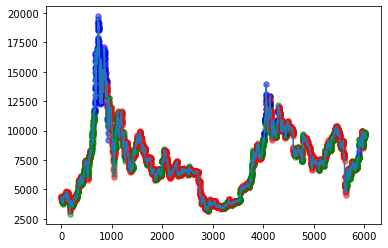

In [90]:
indexs = [x for x,_ in enumerate(raw_price)]
plt.plot(raw_price)
area = 30
for index,item in enumerate(clustering.labels_):
    if item == 0:
        plt.scatter(index, raw_price[index], s=area, c='red', alpha=0.5)
    if item == 1:
        plt.scatter(index, raw_price[index], s=area, c='green', alpha=0.5)
    if item == 2:
        plt.scatter(index, raw_price[index], s=area, c='blue', alpha=0.5)
    if item == 3:
        plt.scatter(index, raw_price[index], s=area, c='cyan', alpha=0.5)
    if item == 4:
        plt.scatter(index, raw_price[index], s=area, c='yellow', alpha=0.5)

# plot mixture model clustering

In [ ]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

In [ ]:
import itertools
from scipy import linalg
import matplotlib as mpl
color_iter = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'white', 'violet', 'gold', 'lime']
def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(1, 1, 1)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    plt.show()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_encoded)
print(pca.explained_variance_ratio_)
X_encoded_pca = pca.transform(X_encoded)

In [ ]:
plt.scatter(X_encoded_pca[:, 0], X_encoded_pca[:, 1], c=clustering.labels_, s=3, cmap='viridis');

In [ ]:
gmm = GaussianMixture(n_components=2, random_state=42).fit(X_encoded_pca)
plot_results(X_encoded_pca, gmm.predict(X_encoded_pca), gmm.means_, gmm.covariances_, 0, 'Gaussian Mixture')

In [ ]:
dpgmm = BayesianGaussianMixture(n_components=2, random_state=42).fit(X_encoded_pca)
plot_results(X_encoded_pca, dpgmm.predict(X_encoded_pca), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior')

In [ ]:
start_index = 5000
end_index = -1
plot_data = raw_price[start_index: end_index]
indexs = [x for x,_ in enumerate(plot_data)]
plt.plot(indexs, plot_data)
area = 20
prev_label = None
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'white', 'violet', 'gold', 'lime']
labels_proba = dpgmm.predict_proba(X_encoded_pca[start_index:end_index])
for index,item in enumerate(labels_proba):
    cluster = np.argmax(item)
    proba = item[cluster]
    if proba >= 0.75 and prev_label != cluster:
        prev_label = cluster
        plt.scatter(index, plot_data[index], s=area, c=colors[cluster], alpha=1)